In [ ]:
# Install required Python packages:
# - `uncertainties`: Library for error propagation in calculations.
# - `timezones`: Library for handling and converting time zones.
%pip install uncertainties timezones

In [9]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import math as mt
from scipy import stats
from scipy.optimize import curve_fit
import uncertainties.unumpy as unp
import uncertainties as unc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
from scipy.signal import chirp, find_peaks, peak_widths,find_peaks_cwt
from timezonefinder import TimezoneFinder
from timezones import tz_utils
import matplotlib.ticker as ticker

In [5]:
# Define the directory containing processed emission data
datadir = '/home/jovyan/Article_review/Emission_processed_data'

# Define the year for processing (adjustable for different analyses)
Year = 2020

# Example filename format:
# goes_data_emission_rate_amazon_definitive_box_YYYY_150_350.csv
# - YYYY: Year of the data
# - 150_350: Specific time or location identifier

# Retrieve all matching CSV files for the specified year
data = sorted(glob.glob(datadir + '/*goes_data_emission_rate_amazon_definitive_box_' + str(Year) + '_150_350.csv'))
#print(data)  # Uncomment to check the retrieved file list

# Available columns in the dataset:
# 'sat', 'year', 'julian', 'hhmm', 'code', 'central_lat', 'central_lon', 'FRP(MW)', 'N_FRP',
# 'FRE(MJ)', 'RE(kg/s)', 'ME(kg)', 'CO_2(kg)', 'sigma_CO_2(kg)', 'CO(kg)', 'sigma_CO(kg)',
# 'CH4(kg)', 'sigma_CH4(kg)', 'mean_FRP(MW)', 'mean_temp(K)', 'sum_area(m2)', 'mean_area(m2)'

# Select only the relevant columns for analysis
selected_columns = ['central_lat', 'central_lon', 'FRP(MW)', 'hhmm', 'code']

# Read the first available CSV file, extracting only the selected columns
emission_data = pd.read_csv(data[0], usecols=selected_columns)

In [6]:
# Define the bounding box coordinates for a region of interest
# Box 1: For the first example, the bounding box covers a region in the Amazon area
minlon, maxlon, minlat, maxlat = -72, -48, -11, -3  # Example box 1

# Box 2: For the second example, the bounding box covers a different region
#minlon, maxlon, minlat, maxlat = -58, -56, -18, -16 # Example box 2

# Box 3: For the second example, the bounding box covers a different region, smaller, in the Amazon
#minlon, maxlon, minlat, maxlat = -57, -54, -9, -6  # Amazon small box

In [7]:
# Generate evenly spaced grid center points for longitude and latitude
# - The grid spacing is 0.5 degrees (2 points per degree)
centers_lon = np.linspace(minlon + 0.25, maxlon - 0.25, num=int((maxlon - minlon) * 2))
centers_lat = np.linspace(minlat + 0.25, maxlat - 0.25, num=int((maxlat - minlat) * 2))

# Create a matrix of latitude and longitude grid points
for i in range(len(centers_lat)):
    if i == 0:
        # First row: create latitude column and combine with longitude values
        aux = np.repeat(centers_lat[i], len(centers_lon))
        lat_lon_feer = np.column_stack((aux, centers_lon))
    else:
        # Create new row of latitude values and stack it to the existing matrix
        aux = np.repeat(centers_lat[i], len(centers_lon))
        aux2 = np.column_stack((aux, centers_lon))
        lat_lon_feer = np.vstack((lat_lon_feer, aux2))

# Final matrix containing all grid points (latitude, longitude)
matrix = lat_lon_feer

In [8]:
# The FRP (Fire Radiative Power) data is collected, and 'find_peaks' is used to identify peak values.
# It retrieves the fire duration, start, and end times of detected fire events.

# List the data file header
header = list(emission_data)

# Extract latitude values from the dataset
pos1 = header.index('central_lat')
column1 = emission_data.iloc[:, pos1]
lat = np.array(column1.dropna(), dtype=pd.Series)  # Convert to NumPy array, removing NaN values

# Extract longitude values from the dataset
pos2 = header.index('central_lon')
column2 = emission_data.iloc[:, pos2]
lon = np.array(column2.dropna(), dtype=pd.Series)

# Extract FRP values (Fire Radiative Power in MW) from the dataset
pos3 = header.index('FRP(MW)')
column3 = emission_data.iloc[:, pos3]
FRP = np.array(column3.dropna(), dtype=pd.Series)

# Select data points that match the first grid point in the defined region and have valid FRP values
index = np.where((lat == matrix[0, 0]) & (lon == matrix[0, 1]) & (FRP >= 0))
FRP_aux = FRP[index]  # Extract FRP values for the selected indices

# Use 'find_peaks' to identify fire events in the FRP data
peaks, _ = find_peaks(FRP_aux, height=75, distance=50, prominence=750)

# Measure peak widths (fire durations), start, and end times
results_width = peak_widths(FRP_aux, peaks, rel_height=0.95)
fire_duration = (results_width[0] * 10) / 60  # Convert time from 10-minute intervals to hours
peak_start = np.int_(np.floor(results_width[2][:]))  # Start times of peaks
peak_end = np.int_(np.ceil(results_width[3][:]))  # End times of peaks

# Loop through the entire grid of the area of interest
for i in range(1, len(matrix)):
    # Select data points corresponding to the current grid point
    index = np.where((lat == matrix[i, 0]) & (lon == matrix[i, 1]) & (FRP >= 0))
    FRP_aux = FRP[index]

    # Detect fire peaks for the current grid point
    peaks_aux, _ = find_peaks(FRP_aux, height=75, distance=50, prominence=750)
    results_width_aux = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)
    fire_duration_aux = (results_width_aux[0] * 10) / 60  # Convert to hours
    peak_start_aux = np.int_(np.floor(results_width_aux[2][:]))  # Start times
    peak_end_aux = np.int_(np.ceil(results_width_aux[3][:]))  # End times

    # Append results to existing lists
    fire_duration = np.append(fire_duration, fire_duration_aux)
    peaks = np.append(peaks, peaks_aux)
    peak_start = np.append(peak_start, peak_start_aux)
    peak_end = np.append(peak_end, peak_end_aux)

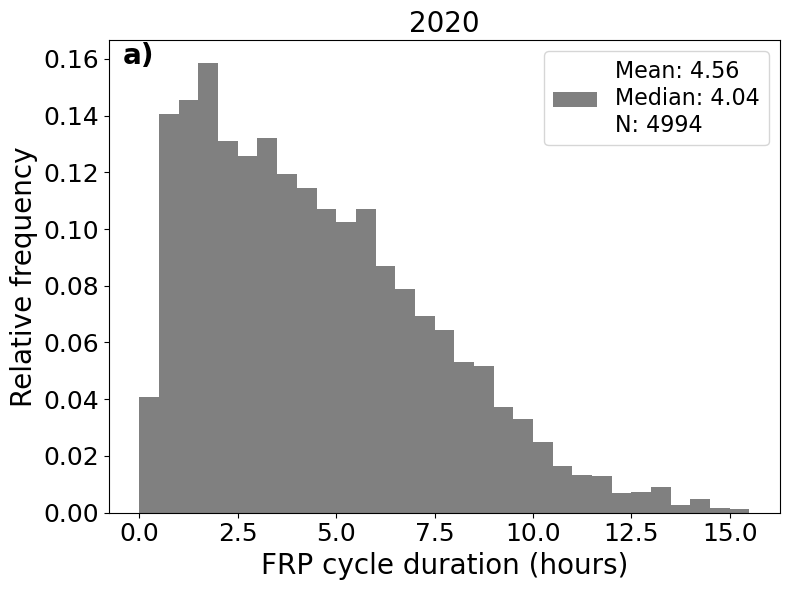

In [10]:
#Plot the distribuition of fire durations

#Configure the plot
plt.figure(figsize=(8, 6))
plt.title(str(Year),fontsize=20)
plt.xlabel('FRP cycle duration (hours)',fontsize=20)
plt.ylabel('Relative frequency',fontsize=20)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.text(0.02, 0.95, 'a)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images

#Define plot limits
limits = [0, 16]
division_points = np.arange(0, 16, 0.5) #Configure the bins

#Plot histogram
plt.hist(fire_duration, bins=division_points, range=limits,density=True,color='gray')
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(fire_duration),np.median(fire_duration),len(fire_duration))
plt.legend([Mean],loc='best',fontsize=16)
plt.tight_layout()

#And save
#pyplot.savefig('filename.png',dpi=300)

<Figure size 640x480 with 0 Axes>

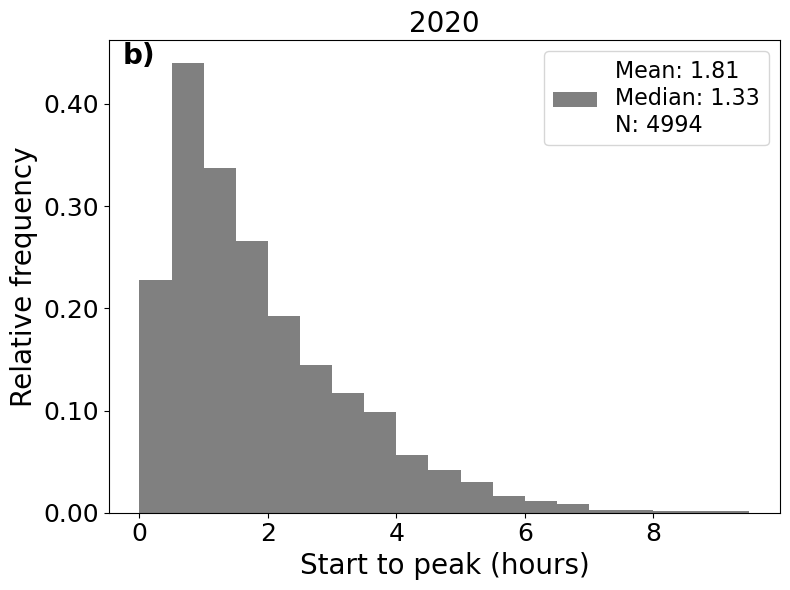

In [11]:
#Plot the distribuition of durations from the start to the peak of fires
#Configure the plot
plt.clf()
plt.figure(figsize=(8, 6))
plt.title(str(Year),fontsize=20)
plt.xlabel('Start to peak (hours)',fontsize=20)
plt.ylabel('Relative frequency',fontsize=20)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.text(0.02, 0.95, 'b)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images

#Calculate the duration from the start to the peak and convert to hours
diff_start_to_peak =  np.subtract(peaks,peak_start)
diff_start_to_peak_minutes =  diff_start_to_peak*10
diff_start_to_peak_hours = diff_start_to_peak_minutes/60

#Define plot limits
limits = [0, 10]
division_points = np.arange(0, 10, 0.5)#Configure the bins

#Plot histogram
plt.hist(diff_start_to_peak_hours, bins=division_points, range=limits,density = True,color='gray')
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(diff_start_to_peak_hours),np.median(diff_start_to_peak_hours),len(diff_start_to_peak_hours))
plt.legend([Mean],loc='best',fontsize=16)
plt.tight_layout()

#And save
#pyplot.savefig('filename.png',dpi=300)

<Figure size 640x480 with 0 Axes>

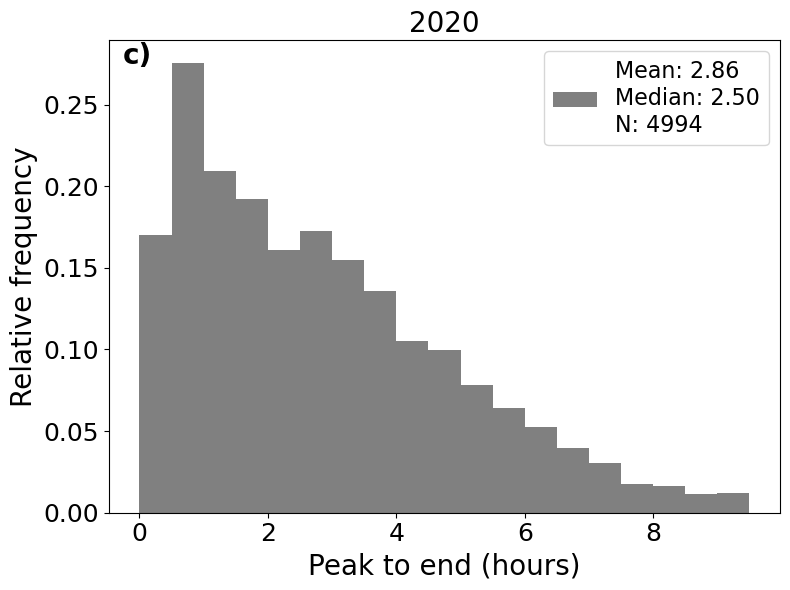

In [12]:
#Plot the distribuition of durations from the peak to the end of fires
#Configure the plot
plt.clf()
plt.figure(figsize=(8, 6))
plt.title(str(Year),fontsize=20)
plt.xlabel('Peak to end (hours)',fontsize=20)
plt.ylabel('Relative frequency',fontsize=20)
plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.text(0.02, 0.95, 'c)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images


#Calculate the duration from the peak to the end and convert to hours
diff_end_to_peak =  np.subtract(peak_end,peaks)
diff_end_to_peak_minutes =  diff_end_to_peak*10
diff_end_to_peak_hours = diff_end_to_peak_minutes/60

#Define plot limits
limits = [0, 10]
division_points = np.arange(0, 10, 0.5)#Configure the bins

#Plot histogram
plt.hist(diff_end_to_peak_hours, bins=division_points, range=limits,density=True,color='gray')
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(diff_end_to_peak_hours),np.median(diff_end_to_peak_hours),len(diff_end_to_peak_hours))
plt.legend([Mean],loc='best',fontsize=16)
plt.tight_layout()

#And save
#plt.savefig('filename.png',dpi=300)

In [14]:
#Function to plot the distribuition of fire start hours
def hist_start_fire_time_distribuition(data_fire,filename,matrix):
    #List the data file header
    header = list(data_fire)

    #Extract the columns of the file
    pos1=header.index('central_lat')
    column1=data_fire.iloc[:,pos1]
    lat = np.array(column1.dropna(), dtype=pd.Series)

    pos2=header.index('central_lon')
    column2=data_fire.iloc[:,pos2]
    lon = np.array(column2.dropna(), dtype=pd.Series)

    pos3=header.index('FRP(MW)')
    column3=data_fire.iloc[:,pos3]
    FRP = np.array(column3.dropna(), dtype=pd.Series)

    pos4=header.index('hhmm')
    column4=data_fire.iloc[:,pos4]
    hhmm = np.array(column4.dropna(), dtype=pd.Series)

    #Index with the conditions: Latitudes and longitudes of grided region of interest and the valid FRP values
    index = np.where((lat==matrix[0,0]) & (lon==matrix[0,1]) & (FRP>=0))

    #The index will select only the latitudes, longitudes and FRP valid values informed on the FRP and hhmm(hour-minute) data columns
    FRP_aux = FRP[index]
    hhmm_aux = hhmm[index]

    #Timezonefinder library helps to find the local timezone to properly calculate the local time that the fire starts
    tf = TimezoneFinder()
    tz = tf.timezone_at(lng=matrix[0,1], lat=matrix[0,0])
    time_zone = np.ones_like(hhmm_aux)*int(tz_utils.format_tz_by_name(tz)[0])
    local_time_aux = np.subtract(hhmm_aux,time_zone*(-1))
    mask = (local_time_aux<0)
    local_time_aux[mask]+=2400

    #Use 'find peaks' the same way that was used in the function 'get_data' to find the start hours in the local time
    peaks_aux, _ = find_peaks(FRP_aux,height=75,distance=50, prominence=750)
    results_width = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)
    index_diff_start_partial = np.int_(np.floor(results_width[2][:]))
    start_hours_local = local_time_aux[index_diff_start_partial]

    #Loop throught all the grid elements
    for i in range(1,len(matrix)):

        index = np.where((lat==matrix[i,0]) & (lon==matrix[i,1])& (FRP>=0))

        FRP_aux = FRP[index]
        hhmm_aux = hhmm[index]
        peaks_aux, _ = find_peaks(FRP_aux,height=75,distance=50, prominence=750)
        results_width_aux = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)

        tz = tf.timezone_at(lng=matrix[i,1], lat=matrix[i,0])
        time_zone = np.ones_like(hhmm_aux)*int(tz_utils.format_tz_by_name(tz)[0])
        local_time_aux = np.subtract(hhmm_aux,time_zone*(-1))
        mask = (local_time_aux<0)
        local_time_aux[mask]+=2400
        index_diff_start_partial = np.int_(np.floor(results_width_aux[2][:]))

        #Save the results in a list
        start_hours_local_aux = local_time_aux[index_diff_start_partial]
        start_hours_local = np.append(start_hours_local,start_hours_local_aux)

    #Configure the plot
    pyplot.clf()
    pyplot.figure(figsize=(5,3.5))
    pyplot.title(str(Year))
    pyplot.xlabel('Fire start hours')
    pyplot.ylabel('Relative frequency')
    pyplot.gca().yaxis.set_major_formatter('{:.2f}'.format)

    #Separate the minutes and hours and convert all to hours
    aux_start_minutes = (start_hours_local%100)
    aux_start_hours = (start_hours_local/100)
    Final_start_hours = aux_start_hours + aux_start_minutes/60


    #Plot the histogram of the distribuition
    pyplot.hist(Final_start_hours,bins=range(0, 24, 1),density=True)
    Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(Final_start_hours),np.median(Final_start_hours),len(Final_start_hours))
    pyplot.legend([Mean],loc='best')

    #And save
    pyplot.savefig(filename+'.png',dpi=200)

    return

In [ ]:
#Linear function
def f(x, a, b):
    return a * x + b
#Prediction bands
def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

#Function to plot the correlation between the fire duration and the FRP emitted
def fire_duration_x_FRP_emitted(data_fire,filename,matrix):
    #List the data file header
    header = list(data_fire)

    #Extract the columns of the file
    pos1=header.index('central_lat')
    column1=data_fire.iloc[:,pos1]
    lat = np.array(column1.dropna(), dtype=pd.Series)

    pos2=header.index('central_lon')
    column2=data_fire.iloc[:,pos2]
    lon = np.array(column2.dropna(), dtype=pd.Series)

    pos3=header.index('FRP(MW)')
    column3=data_fire.iloc[:,pos3]
    FRP = np.array(column3.dropna(), dtype=pd.Series)

    FRP_emitted = []
    #Index with the conditions: Latitudes and longitudes of grided region of interest and the valid FRP values
    index = np.where((lat==matrix[0,0]) & (lon==matrix[0,1]) & (FRP>=0))
    #The index will select only the latitudes, longitudes and FRP valid values informed on the FRP data column
    FRP_aux = FRP[index]

    #Use find peaks the same way that was used in the function 'get_data' to find the start hours in the local time
    peaks_aux, _ = find_peaks(FRP_aux,height=75,distance=50, prominence=750)
    results_width = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)
    fire_duration = (results_width[0]*10)/60
    peak_start = np.int_(np.floor(results_width[2][:]))
    peak_end = np.int_(np.ceil(results_width[2][:]))

    #Using the positions that the fire started and ended calculate the FRP emitted in the interval between them
    for i in range(0,len(peak_start)):

        pos_fire = np.arange(peak_start[i],peak_end[i],1)
        FRP_emitted_aux = np.sum(FRP_aux[pos_fire])
        FRP_emitted = np.append(FRP_emitted,FRP_emitted_aux)


    #Repeat the process for every grid element
    for i in range(1,len(matrix)):
        index = np.where((lat==matrix[i,0]) & (lon==matrix[i,1]) & (FRP>=0))
        FRP_aux = FRP[index]

        peaks_aux, _ = find_peaks(FRP_aux,height=75,distance=50, prominence=750)
        results_width_aux = peak_widths(FRP_aux, peaks_aux, rel_height=0.95)
        fire_duration_aux = (results_width_aux[0]*10)/60
        fire_duration = np.append(fire_duration,fire_duration_aux)
        peak_start = np.int_(np.floor(results_width_aux[2][:]))
        peak_end = np.int_(np.ceil(results_width_aux[2][:]))

        for i in range(0,len(peak_start)):

            pos_fire = np.arange(peak_start[i],peak_end[i],1)
            FRP_emitted_aux = np.sum(FRP_aux[pos_fire])
            FRP_emitted = np.append(FRP_emitted,FRP_emitted_aux)

    #Correlate the results of fire duration and FRP emitted
    fire_duration = np.log(fire_duration[FRP_emitted>0])
    FRP_emitted = np.log(FRP_emitted[FRP_emitted>0])
    popt, pcov = curve_fit(f, fire_duration, FRP_emitted)
    n =len(fire_duration)


    a = popt[0]
    b = popt[1]
    #print('Optimal Values')
    #print('a: ' + str(a))
    #print('b: ' + str(b))

    # compute r^2
    r2 = 1.0-(sum((FRP_emitted-f(fire_duration,a,b))**2)/((n-1.0)*np.var(FRP_emitted,ddof=1)))
    #print('R^2: ' + str(r2))

    # Calculate the pearson coefficient
    r = np.corrcoef(fire_duration, FRP_emitted)[0, 1]

    #print('R pearson: ' + str(r))

    # calculate parameter confidence interval
    a,b = unc.correlated_values(popt, pcov)
    #print('Uncertainty')
    #print('a: ' + str(a))
    #print('b: ' + str(b))

    # calculate regression confidence interval
    px = np.linspace(np.min(fire_duration), np.max(fire_duration), 200)
    py = a*px+b
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)
    lpb, upb = predband(px, fire_duration, FRP_emitted, popt, f, conf=0.95)

    # plot the regression
    plt.clf()
    plt.figure(figsize=(8,6))
    plt.title(str(Year),fontsize=20)

    formatter = ticker.FormatStrFormatter('%.1f')
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.xlabel('ln(∆t/∆t0)',fontsize=20)
    plt.ylabel('ln(FRP/FRP0)',fontsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.text(0.02, 0.95, 'd)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold') #Marker for the article images

    #Plot the data
    plt.plot(fire_duration,FRP_emitted,'*',markersize=1,color='gray')
    labelu = 'y={:.2f}x + {:.2f}\nN = {:.0f}\nr_pearson = {:.2f}'.format(np.mean(a),np.mean(b),len(fire_duration),r)
    plt.plot(px, nom, c='black', label=labelu)
    # uncertainty lines (95% confidence)
    plt.plot(px, nom - 1.96 * std, c='0.4',\
              label='95% Trust region')
    plt.plot(px, nom + 1.96 * std, c='0.4')
    # prediction band (95% confidence)
    plt.plot(px, lpb, 'k--',label='95% Prediction band')
    plt.plot(px, upb, 'k--')
    plt.legend(loc='lower right',fontsize=12)

    #And save
    #plt.savefig(filename+'.png',dpi=300)

    return

<Figure size 640x480 with 0 Axes>

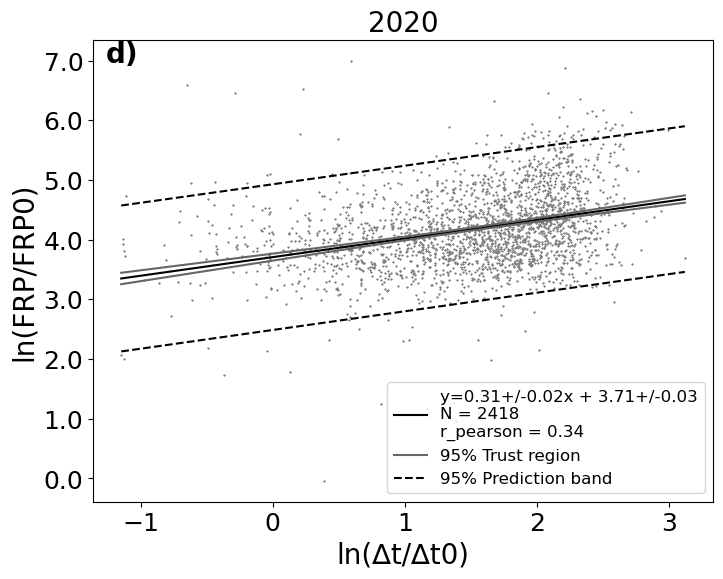

In [15]:
#Call for functions for the plots
fire_duration_x_FRP_emitted(emission_data,'frp_x_fire_duration_'+str(Year)+'_BR163_box',matrix)

In [ ]:
#Call for functions for the plots
hist_start_fire_time_distribuition(emission_data,'peak_start_hours_'+str(Year)+'_amazon_definitive_box',M)

In [16]:
header = list(emission_data)

pos2=header.index('central_lat')
column2=emission_data.iloc[:,pos2]
lat = np.array(column2.dropna(), dtype=pd.Series)

pos4=header.index('central_lon')
column4=emission_data.iloc[:,pos4]
lon = np.array(column4.dropna(), dtype=pd.Series)

pos3=header.index('FRP(MW)')
column3=emission_data.iloc[:,pos3]
FRP = np.array(column3.dropna(), dtype=pd.Series)

pos5=header.index('code')
column5=emission_data.iloc[:,pos5]
code = np.array(column5.dropna(), dtype=pd.Series)

# 7.75,-55.25
# Ramdom 0.5°x0.5° square inside the ROI to plot the FRP and the peaks indentification
index = np.where((lat==-7.75) & (lon==-55.25) & (FRP>=0) & (code>=225) & (code<=235))
FRP_index = FRP[index]
code_full = code[index]

peaks, _ = find_peaks(FRP_index,height=75,distance=50, prominence=750)# 35->75
results_partial = peak_widths(FRP_index, peaks, rel_height=0.95)

peak_start_pos = np.int_(np.floor(results_partial[2][:]))
peak_end_pos = np.int_(np.ceil(results_partial[3][:]))

<bound method Figure.tight_layout of <Figure size 600x400 with 1 Axes>>

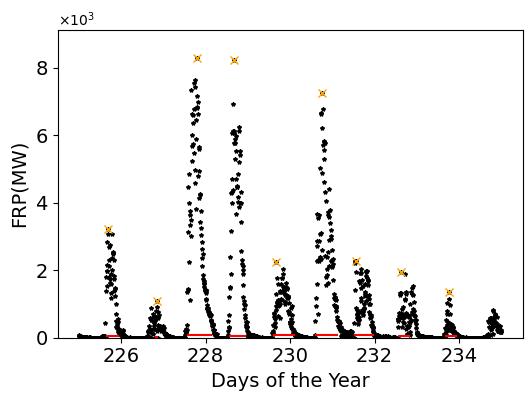

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
#pyplot.title('FRP_distribuition_'+str(Year)+'_with_peaks')
ax.set_ylabel('FRP(MW)', fontsize=14)
ax.set_xlabel('Days of the Year', fontsize=14)
ax.set_ylim(np.min(FRP_index)*1.1,np.max(FRP_index)*1.1)
ax.plot(code_full,FRP_index, '*', markersize=3,label='FRP',color='black')


ax.plot(code_full[peaks], FRP_index[peaks], "x",color='orange')
ax.hlines(results_partial[0],code_full[peak_start_pos],code_full[peak_end_pos], color="red")
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Equivalent to format='%.0e'
# Set scientific notation for y-axis
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Scientific notation outside this range
ax.yaxis.set_major_formatter(formatter)

ax.tick_params(axis='both', labelsize=14)  # Adjust font size for major ticks
fig.tight_layout
#fig.savefig('teste'+'.png',dpi=200)
################################################################################################